# Fitting encoding models to a single session and probe insertion

This notebook aims to introduce you to the methodology behind the analyses of single-unit encoding models. Beginning with loading in session and spiking data, we will generate a design matrix for that data and then fit the neurons within using said matrix. This script will fit a regularized linear model that is used in the paper.

## Loading in data

We begin by first loading in the trials dataframe, spikes, and cluster information (such as QC metrics and brain region labels) for a given session ID and probe ID.

In [1]:
import numpy as np
from one.api import ONE
from brainwidemap.encoding.utils import load_regressors

%matplotlib inline

eid = "034e726f-b35f-41e0-8d6c-a22cc32391fb"
pid = "5e84c8e7-236f-4a64-a944-dc4a17c64f1d"
dt = 0.02  # Time step of the regressor matrix and spike bins

one = ONE(base_url='https://openalyx.internationalbrainlab.org', password='international')
trialsdf, spk_times, spk_clu, clu_regions, clu_df = load_regressors(
    eid, pid, t_before=0.6, t_after=0.6, binwidth=dt, abswheel=True, clu_criteria="bwm", one=one
)


Loading bwm_query results from fixtures/2022_10_bwm_release.csv


NoCredentialsError: Unable to locate credentials

Let's examine the data we just retreived.

- `trialsdf` is a dataframe with per-trial information, including a vector describing the wheel velocity within that trial, binnwed at a binwidth of 20ms. 
- `spk_times` is a 1-dimensional numpy array with times (in seconds relative to session start) at which spikes were detected
- `spk_clu` are the labels associated with those spikes
- `clu_regions` is a list of region labels for all units in the recording
- `clu_df` is a dataframe with additional per-unit information for the units which pass the quality control metrics used in the brain-wide-map paper

In [2]:
trialsdf.head(3)

spk_times

spk_clu

clu_regions[:20]

clu_df.head(3)

One row of trialsdf
 choice                                                               1.0
probabilityLeft                                                      0.5
feedbackType                                                         1.0
feedback_times                                                 25.513533
contrastLeft                                                         1.0
contrastRight                                                        NaN
goCue_times                                                      25.0528
stimOn_times                                                   25.135133
firstMovement_times                                            25.263267
trial_start                                                    24.535133
trial_end                                                      26.113533
wheel_velocity         [0.0, 0.0, 0.0, 0.0015339807878853584, 0.0, 0....
Name: 0, dtype: object
spk_times
 [1.01804053e+00 1.02224053e+00 1.02620720e+00 ... 3.82775259e+03
 3.8

## Constructing a design matrix

We will use these data to next construct a `neurencoding.design.DesignMatrix` object. This is the core specification of how we want to predict single-unit firing. The design matrix at its heart is a nT x nR matrix, where there are N timesteps rows and N regressors columns. The DesignMatrix object helps construct this matrix and also provides useful information about groups of regressors parameterized by basis functions.

To begin with we must choose basis functions describing activity after events. We will use nonlinear raised-cosine basis functions for every regressors. Note that we reverse the basis functions for the first-movement and wheel regressors, and these are anti-causal kernels. This means bases will be more dense at the end of the set.

Note that because we use 300ms wheel and 200ms first-movement bases, with a -300ms and -200ms offset respectively, this ends up producing anti-causal kernels for those regressors. This means that the model will try to fit neural data *preceding* a given wheel movement or movement onset event.

In [3]:
import matplotlib.pyplot as plt
from neurencoding.utils import nonlinear_rcos
from brainwidemap.encoding.design import generate_design

# Both the design matrix and GLM require a binning function to be passed which converts time
# to a bin index. Here we use a lambda function to do this, but you could also define a
# function and pass that instead. Note that this is a ceiling operation that maps time such that
# bin 1 will contain all values of t backwards from dt to 0.
binfun = lambda t: np.ceil(t / dt).astype(int)

# The below parameters are those used in the paper, where you can find the motivation for each
# choice of parameter
bases = {  # Note that these are the basis function sets used in the paper, 
           # motivated by the cross-correlation of firing rates with each of the regressors,
           # together with a descire to use the minimum number of basis functions possible
    "stim": nonlinear_rcos(0.4, 5, 0.1, binfun),
    "feedback": nonlinear_rcos(0.4, 5, 0.1, binfun),
    "wheel": nonlinear_rcos(0.3, 3, 0.05, binfun)[::-1],
    "fmove": nonlinear_rcos(0.2, 3, 0.05, binfun)[::-1],
}
design_matrix = generate_design(
    trialsdf, # The dataframe describing the trial timings
    trialsdf["probabilityLeft"], # The column in that df we want to use as our prior term
    t_before=0.6, # T before stim on to include in DM. Must match t_before in load_regressors
    bases=bases, # Bases to use for each regressor
    iti_prior_win=[-0.4, -0.1], # Window for the ITI prior term, w.r.t. stim on
    fmove_offset=-0.2, # Offset for the first movement bases relative to movement onset
    wheel_offset=-0.3, # Offset for the wheel bases relative to the wheel trace
    contnorm=5.0, # Normalization factor for stimulus contrasts (see Roy et al.)
    binwidth=dt, # Binwidth for the design matrix
    reduce_wheel_dim=False, # Whether to reduce the wheel dimension to fewer bases
)


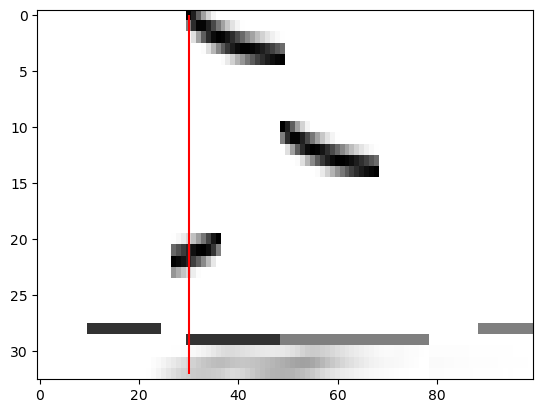

In [4]:
# Let's inspect the first few rows of the design matrix
# The actual design matrix is accessible via the .dm attribute of the object
plt.imshow(design_matrix.dm[:100, :].T, aspect="auto", cmap="gray_r")
# Show a red line at the start of the bin where the trial starts
plt.vlines(binfun(trialsdf["stimOn_times"].loc[0] - trialsdf["trial_start"].loc[0])-1, 0, 32, color="r")

We can see from the `plt.imshow` image map of the design matrix that several things are happening in these first few rows. Several separate kernels are nonzero at varying times. We can inspect the columns from the design matrix that these come from via the `.covar` attribute of the object, which contains information about each regressor:

Keys of the covar attribute, which is a dict: dict_keys(['stimonL', 'stimonR', 'correct', 'incorrect', 'fmoveL', 'fmoveR', 'pLeft', 'pLeft_tr', 'wheel'])


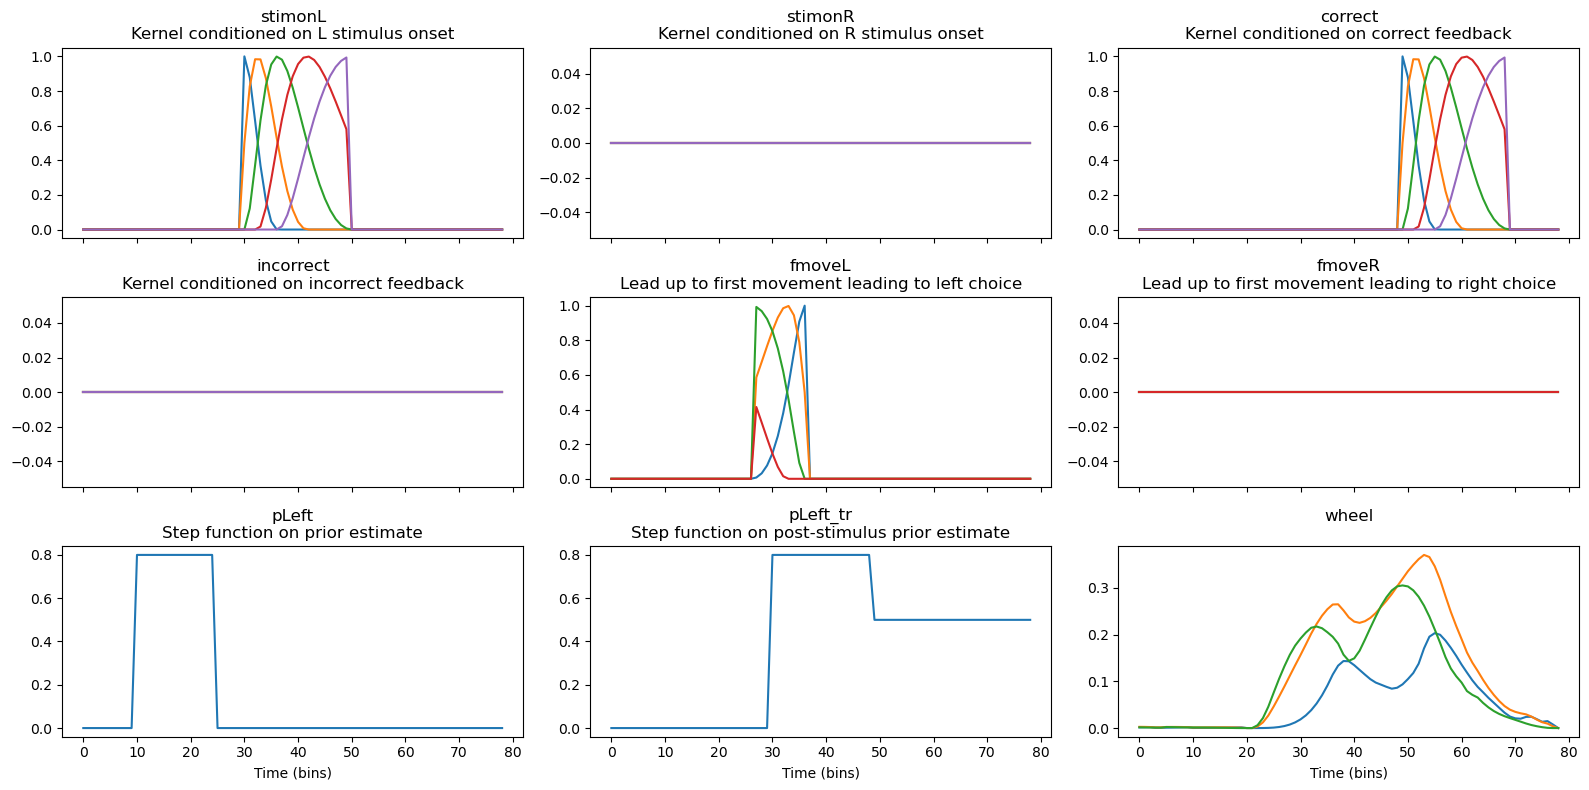

In [9]:
print("Keys of the covar attribute, which is a dict:", design_matrix.covar.keys())
trial_idx = 0  # We will look at the first trial in this session
trialinds = np.argwhere(design_matrix.trlabels == trial_idx)[:, 0]
fig, ax = plt.subplots(3, 3, figsize=(16, 8), sharex=True)
ax = ax.flatten()
for i, cov in enumerate(design_matrix.covar.keys()):
    # design_matrix.covar contains per-covariate information for each regressor we added to the design matrix.
    # The columns in the matrix corresponding to this covariate are stored in the "dmcol_idx" key
    dmcols = design_matrix.covar[cov]["dmcol_idx"]
    ax[i].plot(design_matrix.dm[trialinds][:, dmcols])
    ax[i].set_title(cov + "\n" + design_matrix.covar[cov]["description"])
    if i in [6, 7, 8]:
        ax[i].set_xlabel("Time (bins)")
plt.tight_layout()

In this first trial the animal was presented a left stimulus. This means that the right stimulus kernel is set to zero for this trial. Because the animal correctly chose left, the right first movement kernel is also zero, as is the incorrect kernel. 

Each one of the traces above will be fit with a separate weight in the model. However when running the leave-one-out analysis the traces will be added and removed in groups by regressor.

## Fitting the model once, without cross-validation

Let's now fit this model to the neurons for which we have spikes. We begin by creating a neurencoding model object for a linear model.

In [12]:
from neurencoding.linear import LinearGLM
from brainwidemap.encoding.fit import fit
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# We need to define an estimator for the fitting function to use.
# Here we use ridge regression with a grid search over the regularization parameter using
# 5-fold cross-validation to test the value of alpha.
estimator = GridSearchCV(Ridge(), {"alpha": np.logspace(-3, 3, 7)}, cv=5)
# We will fit the model once without cross validation
# so we can look at the output weights (the above cross validation is only used to select the
# regularization parameter)
nglm = LinearGLM(
    design_matrix=design_matrix,
    spk_times=spk_times,
    spk_clu=spk_clu,
    binwidth=dt,
    estimator=estimator,
)
nglm.fit()
print(nglm.clu_ids)

Condition of design matrix is 110.43522950343353
[ 59  69  77  82  94 102 103 105 119 125 163 173 177 183 185 190 191 196
 204 217 237]


Note that when we fit the above model, a condition number was printed. This condition number is the ratio of the largest eigenvalue to the smallest eigenvalue of the design matrix. It effectively describes how difficult the fitting will be given this matrix, as a large condition number means very high degrees of colinearity. Smaller is better here.

Before we look at the full fitting procedure used in the paper, let's see what the fit model looks like:

ITI prior weight: 0.053301149495970986
Within-trial prior weight: -0.003280345220065159


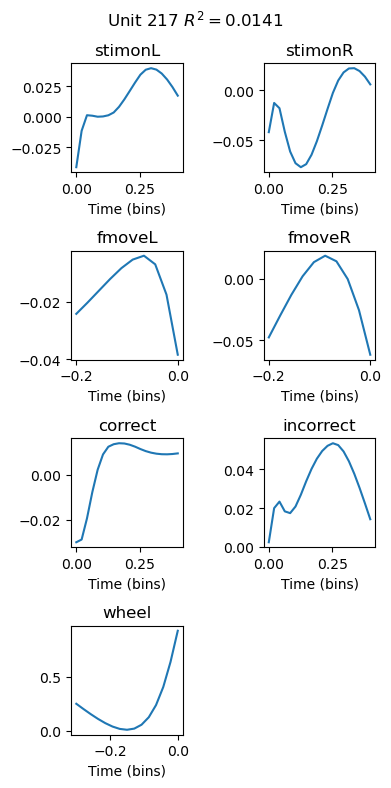

In [13]:
clu_id = 217  # Change to look at different units from the list above
# The .combine_weights() method combines the weights and basis functions for regressors which use
# them, i.e. producing a weighted sum of bases, and returns a dict of dataframes with the resulting
# weights. 
# 
# Note that the ITI and within-trial P(Left) regressors do not use basis functions as you
# can see in the plots of DM columns above
# 
# Let's look at these for one unit. Note that for regressors not using bases the output
# is a single scalar value.
combweights = nglm.combine_weights()
print("ITI prior weight:", combweights["pLeft"].loc[clu_id])
print("Within-trial prior weight:", combweights["pLeft_tr"].loc[clu_id])
fig, ax = plt.subplots(4, 2, figsize=(4, 8))
ax = ax.flatten()
for i, kern in enumerate(
    ["stimonL", "stimonR", "fmoveL", "fmoveR", "correct", "incorrect", "wheel"]
):
    ax[i].plot(combweights[kern].loc[clu_id])
    ax[i].set_title(kern)
    ax[i].set_xlabel("Time (bins)")
ax[-1].remove()
plt.suptitle(f"Unit {clu_id} $R^2 = {nglm.score().loc[clu_id]:0.4f}$")
plt.tight_layout()


Here we see the component kernels for each regressor that emerge after fitting and combining the basis functions using the fit weights. Note the different Y-axis scales on each of these plots, showing that there are very different degrees of contribution to the firing of the unit.

Note that while the wheel kernel goes from -0.3 to 0s the actual signal is present throughout the whole trial. This is because the kernel is convolved with the wheel signal to produce a regressor trace. When compared against the original trace, because of this negative offset, the regressor trace will be shifted backwards in time. This is because we hope to explain activity _before_ a given wheel movement.

This is well and good, and the resulting $R^2$ of 0.0141 is not bad, but we don't really have an idea of how this compares against the actual neural responses to these variables. A better way would be to compare the PETHs for the variables above (where possible) against the  predicted responses of the model.

Luckily, the `GLMPredictor` class in `brainwidemap.encoding.glm_predict` allows us to do exactly that.

Text(0.5, 0.98, 'Unit 282 from region LD')

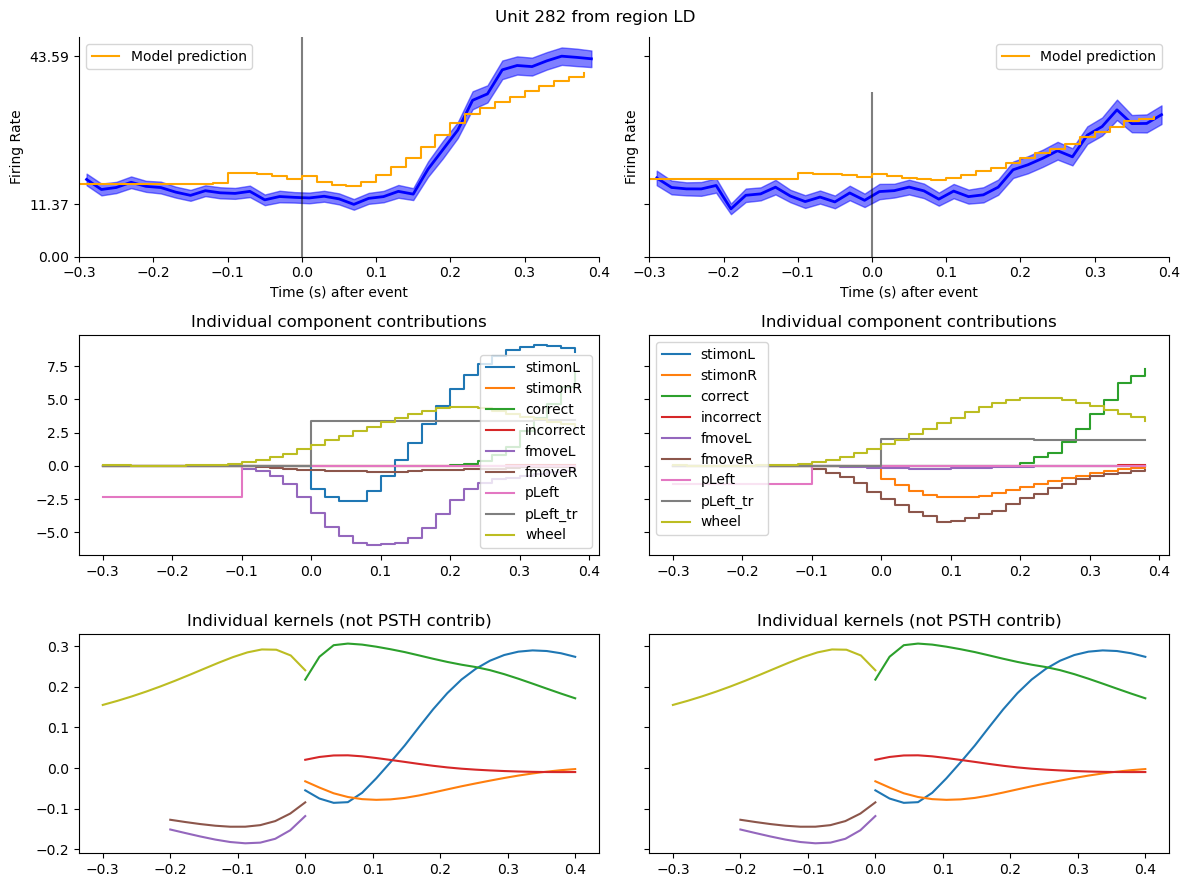

In [ ]:
import brainwidemap.encoding.glm_predict as gp
from importlib import reload
reload(gp)
pred = gp.GLMPredictor(trialsdf, nglm, spk_times, spk_clu)
fig, ax = plt.subplots(3, 2, figsize=(12, 9), sharey="row")
# Let's look at the kernel for left stimulus. We will use the .psth_summary() method to plot the
# PSTH for the left stimulus trials and the right stimulus trials separately, and compare
# the predicted firing and kernel contributions for each condition.
pred.psth_summary(
    align_time="stimOn_times",
    unit=clu_id,
    t_before=0.3,
    t_after=0.4,
    trials=trialsdf.index[np.isfinite(trialsdf["contrastRight"])],
    ax=ax[:, 1],
)
pred.psth_summary(
    align_time="stimOn_times",
    unit=clu_id,
    t_before=0.3,
    t_after=0.4,
    trials=trialsdf.index[np.isfinite(trialsdf["contrastLeft"])],
    ax=ax[:, 0],
)
plt.suptitle(f"Unit {clu_id} from region {clu_regions[clu_id]}")


Much better. Here we can see exactly how different the two conditions (L/R) are, which are plotted in the columns of the plot. The first row shows the PSTH of firing around stimulus onset as compared to the model predictions, while the second row shows the contributions of each regressor in the model to that prediction of firing rate. The third row is a summary of the previous plot, putting all of the kernels fit to the unit on the same axis and scale.

## Leave-one-out analysis (stepwise regression)

What if we want to quantify the exact impact on the score of our model by each of our regressors? In the paper, we do this using a leave-one-out methodology in which the full model is first fit, then each regressor is taken out and the model refit. The difference in score is then reported.

In [ ]:
from brainwidemap.encoding.fit import fit_stepwise

# We will do a sequential feature selection with 8 features (one less than the number we have)
# and use the backward direction (i.e. we start with all features and remove one at a time)
# then we can compare the full model against the less-one-regressor models.
# NB: This is a very slow process, expect it to take several minutes if you have less than 16 cores.
results = fit_stepwise(
    design=design_matrix,
    spk_t=spk_times,
    spk_clu=spk_clu,
    binwidth=dt,
    model=LinearGLM,
    estimator=estimator,
    seqsel_kwargs={"n_features_to_select": 8, "direction": "backward"},
    seqselfit_kwargs={"full_scores": True},
)


stimonL      0.008991
stimonR      0.000381
correct      0.030726
incorrect    0.000025
fmoveL       0.004465
fmoveR       0.001995
pLeft        0.001235
pLeft_tr     0.005073
wheel        0.005048
Name: 282, dtype: object


<AxesSubplot: xlabel='variable', ylabel='value'>

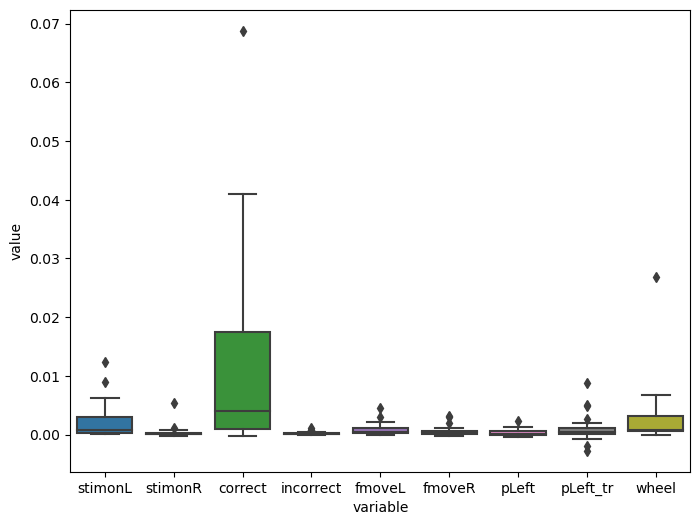

In [ ]:
import seaborn as sns
# The results dictionary contains 'scores', 'deltas', 'sequences', and 'splits'. These,
# respectively, are the scores of the models, the change in score from the previous model,
# the sequence of regressors in each model, and the indices of the trials used in each
# cross-validation fold. We will only look at the deltas here.
print(results["deltas"][0]["test"].loc[clu_id])

We can see that in fact while the weight for the left stimulus onset kernel is high, it does not affect the score of the model much when removed. The correct kernel, however, explains much variance for this unit that cannot be explained otherwise.

## Wrapping up

These are the key components of the encoding models used in this repo. While there are other utilities available this covers the key parts necessary to run the analyses in the brain wide map paper.